# Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from pyproj import Transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Constants
WINDOW_SIZE = 8    # past 8 steps = 24 h
HORIZON = 1        # next 1 step = 3 h
REQUIRED_WINDOWS = 10
MIN_LENGTH = WINDOW_SIZE + HORIZON + REQUIRED_WINDOWS - 1  # 18

# Data Loading

In [3]:
# Data URL
URL = (
    "https://www.ncei.noaa.gov/data/"
    "international-best-track-archive-for-climate-stewardship-ibtracs/"
    "v04r00/access/csv/ibtracs.NA.list.v04r00.csv"
)

In [4]:
# Load the IBTrACS dataset
df = pd.read_csv(URL, low_memory=False)
print(f"Loaded {len(df):,} records")
display(df)

Loaded 126,971 records


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 12:00:00,TS,26.1000,-90.4000,...,,,,,,,,,6,291
2,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 15:00:00,TS,26.2001,-90.6999,...,,,,,,,,,6,290
3,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 18:00:00,TS,26.3000,-91.0000,...,,,,,,,,,6,290
4,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 21:00:00,TS,26.3999,-91.3001,...,,,,,,,,,6,290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126966,2023321N15278,2023,79,NaN,CS,NOT_NAMED,2023-11-17 12:00:00,NR,17.0364,-79.8000,...,,,,,,,,,15,49
126967,2023321N15278,2023,79,NaN,CS,NOT_NAMED,2023-11-17 15:00:00,NR,17.5021,-79.1718,...,,,,,,,,,16,52
126968,2023321N15278,2023,79,NaN,CS,NOT_NAMED,2023-11-17 18:00:00,NR,18.0000,-78.5000,...,,,,12,,120,,,17,49
126969,2023321N15278,2023,79,NaN,CS,NOT_NAMED,2023-11-17 21:00:00,NR,18.5966,-77.8436,...,,,,,,,,,18,45


In [5]:
# Remove the first row which contains units information
df = df[1:].reset_index(drop=True)
print(f"After removing units row: {len(df):,} records")
display(df)

After removing units row: 126,970 records


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 12:00:00,TS,26.1000,-90.4000,...,,,,,,,,,6,291
1,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 15:00:00,TS,26.2001,-90.6999,...,,,,,,,,,6,290
2,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 18:00:00,TS,26.3000,-91.0000,...,,,,,,,,,6,290
3,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 21:00:00,TS,26.3999,-91.3001,...,,,,,,,,,6,290
4,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-24 00:00:00,TS,26.5000,-91.6000,...,,,,,,,,,6,290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126965,2023321N15278,2023,79,NaN,CS,NOT_NAMED,2023-11-17 12:00:00,NR,17.0364,-79.8000,...,,,,,,,,,15,49
126966,2023321N15278,2023,79,NaN,CS,NOT_NAMED,2023-11-17 15:00:00,NR,17.5021,-79.1718,...,,,,,,,,,16,52
126967,2023321N15278,2023,79,NaN,CS,NOT_NAMED,2023-11-17 18:00:00,NR,18.0000,-78.5000,...,,,,12,,120,,,17,49
126968,2023321N15278,2023,79,NaN,CS,NOT_NAMED,2023-11-17 21:00:00,NR,18.5966,-77.8436,...,,,,,,,,,18,45


# Data Exploration

In [6]:
# List of columns
df.columns.tolist()

['SID',
 'SEASON',
 'NUMBER',
 'BASIN',
 'SUBBASIN',
 'NAME',
 'ISO_TIME',
 'NATURE',
 'LAT',
 'LON',
 'WMO_WIND',
 'WMO_PRES',
 'WMO_AGENCY',
 'TRACK_TYPE',
 'DIST2LAND',
 'LANDFALL',
 'IFLAG',
 'USA_AGENCY',
 'USA_ATCF_ID',
 'USA_LAT',
 'USA_LON',
 'USA_RECORD',
 'USA_STATUS',
 'USA_WIND',
 'USA_PRES',
 'USA_SSHS',
 'USA_R34_NE',
 'USA_R34_SE',
 'USA_R34_SW',
 'USA_R34_NW',
 'USA_R50_NE',
 'USA_R50_SE',
 'USA_R50_SW',
 'USA_R50_NW',
 'USA_R64_NE',
 'USA_R64_SE',
 'USA_R64_SW',
 'USA_R64_NW',
 'USA_POCI',
 'USA_ROCI',
 'USA_RMW',
 'USA_EYE',
 'TOKYO_LAT',
 'TOKYO_LON',
 'TOKYO_GRADE',
 'TOKYO_WIND',
 'TOKYO_PRES',
 'TOKYO_R50_DIR',
 'TOKYO_R50_LONG',
 'TOKYO_R50_SHORT',
 'TOKYO_R30_DIR',
 'TOKYO_R30_LONG',
 'TOKYO_R30_SHORT',
 'TOKYO_LAND',
 'CMA_LAT',
 'CMA_LON',
 'CMA_CAT',
 'CMA_WIND',
 'CMA_PRES',
 'HKO_LAT',
 'HKO_LON',
 'HKO_CAT',
 'HKO_WIND',
 'HKO_PRES',
 'NEWDELHI_LAT',
 'NEWDELHI_LON',
 'NEWDELHI_GRADE',
 'NEWDELHI_WIND',
 'NEWDELHI_PRES',
 'NEWDELHI_CI',
 'NEWDELHI_DP',
 'N

In [7]:
# Count of unique storms
unique_storms = df['SID'].nunique()
print(f"Total unique storms in the dataset: {unique_storms:,}")

Total unique storms in the dataset: 2,344


In [8]:
# Range of years
df['SEASON'] = pd.to_numeric(df['SEASON'], errors='coerce')
min_year = df['SEASON'].min()
max_year = df['SEASON'].max()
print(f"Year range: {int(min_year)} to {int(max_year)}")

Year range: 1851 to 2023


In [9]:
# Count of storms per year
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
df['YEAR'] = df['ISO_TIME'].dt.year
year_counts = df.groupby('YEAR')['SID'].nunique().sort_index()
print("Storms per year (last 10 years):")
print(year_counts.tail(10).iloc[::-1])

Storms per year (last 10 years):
YEAR
2023    21
2022    17
2021    21
2020    31
2019    20
2018    16
2017    19
2016    16
2015    12
2014     9
Name: SID, dtype: int64


In [10]:
# Check storm name for a specific SID
sid_to_check = '2022270N14324'
name_value = df.loc[df['SID'] == sid_to_check, 'NAME']
print(f"NAME for SID {sid_to_check}: {name_value.values[0]}")

NAME for SID 2022270N14324: NOT_NAMED


In [11]:
def visualize_storm_tracks(
    df,
    n_storms=5,
    min_observations=10,
    save_path='sample_storm_tracks.png'
):
    """
    Visualize tracks of random storms with sufficient observations

    Parameters:
    - df: DataFrame with storm data
    - n_storms: Number of storms to visualize
    - min_observations: Minimum number of observations required per storm
    - save_path: Path to save the visualization
    """
    # Convert coordinates to numeric
    df['LAT'] = pd.to_numeric(df['LAT'], errors='coerce')
    df['LON'] = pd.to_numeric(df['LON'], errors='coerce')

    # Get storms with sufficient observations
    storm_counts = df.groupby('SID').size()
    valid_storms = storm_counts[storm_counts >= min_observations].index.tolist()

    if len(valid_storms) == 0:
        print(f"No storms found with at least {min_observations} observations")
        return

    # Select random storms
    selected_sids = np.random.choice(
        valid_storms,
        min(n_storms, len(valid_storms)),
        replace=False
    )

    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    # Track bounds
    all_lons = []
    all_lats = []

    # Plot each selected storm
    colors = plt.cm.tab10(np.linspace(0, 1, len(selected_sids)))
    for i, sid in enumerate(selected_sids):
        storm_data = df[df['SID'] == sid].sort_values('ISO_TIME')
        storm_data = storm_data.dropna(subset=['LAT', 'LON'])

        if len(storm_data) > 0:
            storm_year = int(storm_data['SEASON'].iloc[0]) if not pd.isna(storm_data['SEASON'].iloc[0]) else 'Unknown'
            storm_name = storm_data['NAME'].iloc[0] if 'NAME' in storm_data.columns and not pd.isna(storm_data['NAME'].iloc[0]) else 'UNNAMED'
            # Clean up storm name formatting
            storm_name = str(storm_name).strip().title()
            if storm_name.upper() in ['NOT_NAMED', 'NOT NAMED', 'UNNAMED', '']:
                storm_name = 'Unnamed'

            # Plot the track line
            ax.plot(
                storm_data['LON'],
                storm_data['LAT'],
                color=colors[i],
                linewidth=2,
                alpha=0.6,
                label=f"{sid} - {storm_name} ({storm_year})"
            )

            # Plot markers for each data point
            ax.scatter(
                storm_data['LON'],
                storm_data['LAT'],
                color=colors[i],
                s=30,
                alpha=0.8,
                zorder=5
            )

            # Mark start and end points with special markers
            ax.plot(
                storm_data['LON'].iloc[0],
                storm_data['LAT'].iloc[0],
                'o',
                color=colors[i],
                markersize=10,
                markeredgecolor='black',
                markeredgewidth=2,
                zorder=6
            )
            ax.plot(
                storm_data['LON'].iloc[-1],
                storm_data['LAT'].iloc[-1],
                's',
                color=colors[i],
                markersize=10,
                markeredgecolor='black',
                markeredgewidth=2,
                zorder=6
            )

            # Collect coordinates for bounds
            all_lons.extend(storm_data['LON'].values)
            all_lats.extend(storm_data['LAT'].values)

    # Set intelligent axis limits with padding
    if all_lons and all_lats:
        lon_range = max(all_lons) - min(all_lons)
        lat_range = max(all_lats) - min(all_lats)
        padding = 0.1  # 10% padding

        ax.set_xlim(
            min(all_lons) - lon_range * padding,
            max(all_lons) + lon_range * padding
        )
        ax.set_ylim(
            min(all_lats) - lat_range * padding,
            max(all_lats) + lat_range * padding
        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Sample of {len(selected_sids)} Storm Tracks from IBTrACS Dataset\n(Minimum {min_observations} observations per storm)')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_aspect('auto')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    # Print details
    print(f"\nDetails of visualized storms:")
    for sid in selected_sids:
        storm_data = df[df['SID'] == sid]
        year = storm_data['SEASON'].iloc[0]
        num_points = len(storm_data)
        year_str = f"{int(year)}" if not pd.isna(year) else "Unknown"
        storm_name = storm_data['NAME'].iloc[0] if 'NAME' in storm_data.columns and not pd.isna(storm_data['NAME'].iloc[0]) else 'UNNAMED'
        storm_name = str(storm_name).strip().title()
        if storm_name.upper() in ['NOT_NAMED', 'NOT NAMED', 'UNNAMED', '']:
            storm_name = 'Unnamed'
        print(f"  - {sid} - {storm_name}: Year {year_str}, {num_points} data points")

Visualizing random storm tracks...



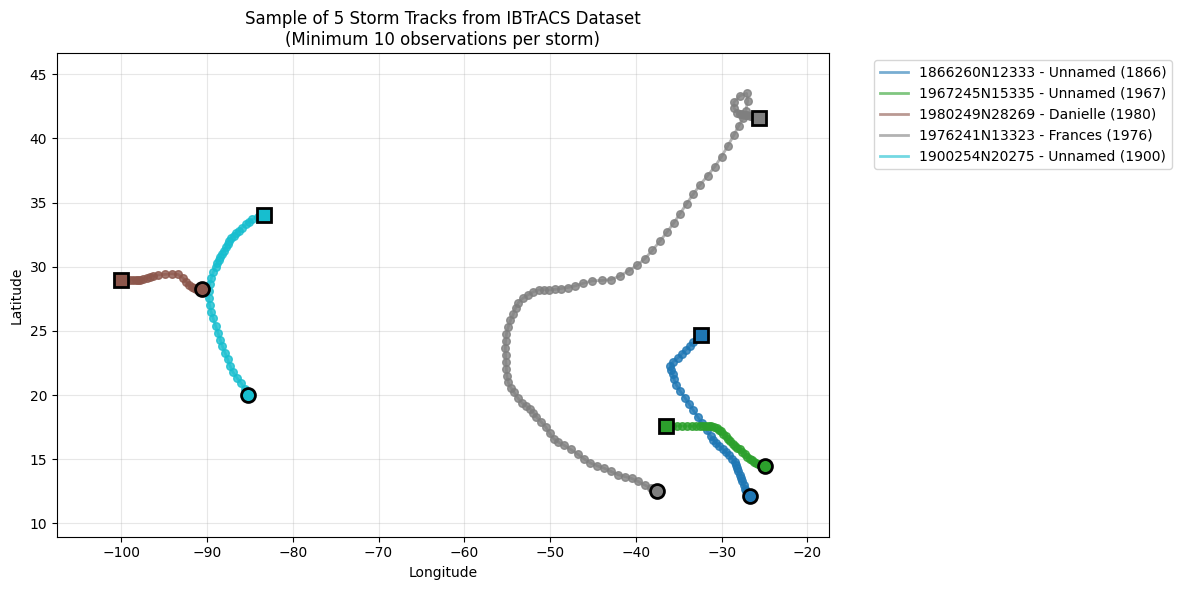


Details of visualized storms:
  - 1866260N12333 - Unnamed: Year 1866, 41 data points
  - 1967245N15335 - Unnamed: Year 1967, 35 data points
  - 1980249N28269 - Danielle: Year 1980, 23 data points
  - 1976241N13323 - Frances: Year 1976, 89 data points
  - 1900254N20275 - Unnamed: Year 1900, 39 data points


In [12]:
# Call the visualization function
print("Visualizing random storm tracks...\n")
np.random.seed(42)
visualize_storm_tracks(df, n_storms=5, min_observations=10)

In [13]:
def check_key_columns_missing(df, key_columns):
    """
    Check for missing values (NaN, Null, None, whitespace, empty strings) in specific columns

    Parameters:
    - df: DataFrame to check
    - key_columns: List of column names to check for missing values

    Returns:
    - Dictionary with column names as keys and missing value counts as values
    """
    missing_counts = {}

    for col in key_columns:
        if col in df.columns:
            # Count NaN values
            nan_count = df[col].isnull().sum()

            # For string columns, also check for empty strings and whitespace
            if df[col].dtype == 'object':
                # Count empty strings (not NaN)
                empty_count = ((df[col].notna()) & (df[col] == '')).sum()
                # Count whitespace only (not NaN, not empty)
                whitespace_count = ((df[col].notna()) & (df[col] != '') & (df[col].str.strip() == '')).sum()
                # Count none/null indicators
                none_indicators = ['none', 'None', 'NONE', 'null', 'Null', 'NULL']
                none_count = ((df[col].notna()) & (df[col].isin(none_indicators))).sum()
                # Total missing
                total_missing = nan_count + empty_count + whitespace_count + none_count
            else:
                total_missing = nan_count

            missing_counts[col] = total_missing
        else:
            missing_counts[col] = -1  # Indicator that column does not exist

    return missing_counts

In [14]:
# Check missing values in key columns
print("Missing values in key columns:")
key_columns_to_check = [
    'SID',
    'SEASON',
    'NUMBER',
    'BASIN',
    'SUBBASIN',
    'NAME',
    'ISO_TIME',
    'NATURE',
    'LAT',
    'LON',
    'TRACK_TYPE',
    'DIST2LAND',
    'LANDFALL',
    'IFLAG',
    'STORM_SPEED',
    'STORM_DIR'
]
key_missing = check_key_columns_missing(df, key_columns_to_check)
for col, count in key_missing.items():
    if count >= 0:
        percent = (count / len(df)) * 100
        print(f"  {col}: {count:,} missing ({percent:.2f}%)")
    else:
        print(f"  {col}: Column not found in dataset")

Missing values in key columns:
  SID: 0 missing (0.00%)
  SEASON: 0 missing (0.00%)
  NUMBER: 0 missing (0.00%)
  BASIN: 126,392 missing (99.54%)
  SUBBASIN: 96,909 missing (76.32%)
  NAME: 0 missing (0.00%)
  ISO_TIME: 0 missing (0.00%)
  NATURE: 0 missing (0.00%)
  LAT: 0 missing (0.00%)
  LON: 0 missing (0.00%)
  TRACK_TYPE: 0 missing (0.00%)
  DIST2LAND: 0 missing (0.00%)
  LANDFALL: 2,344 missing (1.85%)
  IFLAG: 0 missing (0.00%)
  STORM_SPEED: 29 missing (0.02%)
  STORM_DIR: 29 missing (0.02%)


In [15]:
# Check data statistics
print(f"Coordinate ranges:")
print(f"  Latitude: {df['LAT'].min():.2f} to {df['LAT'].max():.2f}")
print(f"  Longitude: {df['LON'].min():.2f} to {df['LON'].max():.2f}")

Coordinate ranges:
  Latitude: 7.00 to 83.01
  Longitude: -136.90 to 63.00


# Data Filtering

In [16]:
# Convert LAT and LON data
df['LAT'] = pd.to_numeric(df['LAT'], errors='coerce')
df['LON'] = pd.to_numeric(df['LON'], errors='coerce')
df = df.dropna(subset=['LAT', 'LON'])
df = df[(df['LAT'].abs() <= 90) & (df['LON'].abs() <= 180)]

In [17]:
# Filter out pre-1900 storms
df = df[df['YEAR'] >= 1900].copy()
print(f"After filtering pre-1900 data: {len(df):,} records")
print(f"Number of storms: {df['SID'].nunique()}")

After filtering pre-1900 data: 89,234 records
Number of storms: 1630


In [18]:
# Filter storms by minimum length required
counts = df['SID'].value_counts()
valid_sids = counts[counts >= MIN_LENGTH].index
df = df[df['SID'].isin(valid_sids)].copy()
print(f"After minimum length filter: {len(df):,} records")
print(f"Number of storms: {df['SID'].nunique()}")

After minimum length filter: 87,013 records
Number of storms: 1464


In [19]:
# Rename LON and LAT
df.rename(columns={'LON': 'x', 'LAT': 'y'}, inplace=True)

In [20]:
# Ensure data is properly sorted
df.sort_values(['SID', 'ISO_TIME'], inplace=True)

# Model Training

In [21]:
# Extract storm metadata
storm_start = df.groupby('SID')['ISO_TIME'].min().to_dict()
storm_years = df.groupby('SID')['YEAR'].first().to_dict()

In [22]:
# Determine test years
available_years = sorted(df['YEAR'].unique())
test_years = [y for y in available_years[-2:] if year_counts.get(y, 0) >= 5]
test_years_int = [int(y) for y in test_years]
print(f"Test years selected: {test_years_int}")

Test years selected: [2022, 2023]


In [23]:
def split_data_by_year(df, storm_years, test_year):
    """Split data into train/test based on year"""
    train_sids = [sid for sid, year in storm_years.items() if year < test_year]
    test_sids = [sid for sid, year in storm_years.items() if year == test_year]

    df_train = df[df['SID'].isin(train_sids)]
    df_test = df[df['SID'].isin(test_sids)]

    return train_sids, test_sids, df_train, df_test

In [24]:
def make_windows(df_in, W, H):
    """Create sliding windows from storm trajectories"""
    Xs, ys, groups, end_times = [], [], [], []
    for sid, grp in df_in.groupby('SID'):
        grp = grp.sort_values('ISO_TIME')
        coords = grp[['x','y']].values
        times = grp['ISO_TIME'].values
        T = len(coords)
        for i in range(W, T - H + 1):
            Xs.append(coords[i-W : i])
            ys.append(coords[i : i+H].ravel())
            groups.append(sid)
            end_times.append(times[i-1])

    if len(Xs) == 0:
        return None, None, None, None

    return (
        np.stack(Xs),
        np.stack(ys),
        np.array(groups),
        np.array(end_times)
    )

In [25]:
# Projection transformers for coordinate conversion
proj_transformer = Transformer.from_crs(
    "EPSG:4326",
    "+proj=lcc +lat_1=30 +lat_2=60 +lat_0=40 +lon_0=-50 +units=km",
    always_xy=True
)
inverse_transformer = Transformer.from_crs(
    "+proj=lcc +lat_1=30 +lat_2=60 +lat_0=40 +lon_0=-50 +units=km",
    "EPSG:4326",
    always_xy=True
)

In [26]:
def project_targets(y_deg, transformer):
    """Project lat/lon targets to km space"""
    lon = y_deg[:,0]
    lat = y_deg[:,1]
    x_km, y_km = transformer.transform(lon, lat)
    return np.column_stack([x_km, y_km])

In [27]:
def storm_age_hours(groups, end_times, storm_start):
    """Calculate storm age in hours"""
    ages = [
        (et - storm_start[sid]) / np.timedelta64(1, 'h')
        for sid, et in zip(groups, end_times)
    ]
    return np.array(ages).reshape(-1, 1)

In [28]:
def time_features(end_times):
    """Extract cyclical time features"""
    ts = pd.to_datetime(end_times)
    sin_doy = np.sin(2*np.pi * ts.dayofyear / 365.25)
    cos_doy = np.cos(2*np.pi * ts.dayofyear / 365.25)
    sin_hr = np.sin(2*np.pi * ts.hour / 24.0)
    cos_hr = np.cos(2*np.pi * ts.hour / 24.0)
    return np.column_stack([sin_doy, cos_doy, sin_hr, cos_hr])

In [29]:
def build_feature_matrix(X, groups, end_times, storm_start):
    """Build complete feature matrix"""
    M = X.shape[0]
    # Project to km space
    lon = X[:,:,0].ravel()
    lat = X[:,:,1].ravel()
    x_proj, y_proj = proj_transformer.transform(lon, lat)
    X_proj = np.column_stack([x_proj, y_proj]).reshape(M, WINDOW_SIZE, 2)

    # Flatten positions
    X_flat = X_proj.reshape(M, -1)

    # Calculate velocities
    vel = np.linalg.norm(np.diff(X_proj, axis=1), axis=2)
    vel_flat = vel.reshape(M, -1)

    # Add time features
    age = storm_age_hours(groups, end_times, storm_start)
    tf = time_features(end_times)

    return np.hstack([X_flat, vel_flat, age, tf])

In [30]:
def prepare_datasets(df_train, df_test, storm_start):
    """Prepare training and test datasets with features"""
    # Create windows
    X_tr, y_tr, g_tr, t_tr = make_windows(df_train, WINDOW_SIZE, HORIZON)
    X_te, y_te, g_te, t_te = make_windows(df_test, WINDOW_SIZE, HORIZON)

    if X_tr is None or X_te is None:
        return None

    # Project targets to km space
    y_tr_proj = project_targets(y_tr, proj_transformer)
    y_te_proj = project_targets(y_te, proj_transformer)

    # Build features
    X_tr_feat = build_feature_matrix(X_tr, g_tr, t_tr, storm_start)
    X_te_feat = build_feature_matrix(X_te, g_te, t_te, storm_start)

    results_dict = {
        'X_train': X_tr,
        'y_train': y_tr,
        'X_train_feat': X_tr_feat,
        'y_train_proj': y_tr_proj,
        'groups_train': g_tr,
        'times_train': t_tr,
        'X_test': X_te,
        'y_test': y_te,
        'X_test_feat': X_te_feat,
        'y_test_proj': y_te_proj,
        'groups_test': g_te,
        'times_test': t_te
    }

    return results_dict

In [31]:
def create_pipeline():
    """Create model pipeline with HistGradientBoostingRegressor"""
    n_features = WINDOW_SIZE * 2 + (WINDOW_SIZE - 1) + 1  # positions + velocities + age

    preprocessor = ColumnTransformer([
        ('scale_numeric', StandardScaler(), list(range(n_features)))
    ], remainder='passthrough')

    pipeline = Pipeline([
        ('preproc', preprocessor),
        ('hgb', MultiOutputRegressor(HistGradientBoostingRegressor(
            max_iter=200,
            max_depth=10,
            learning_rate=0.1,
            min_samples_leaf=20,
            l2_regularization=0.1,
            random_state=42,
            verbose=0
        )))
    ])

    return pipeline

In [32]:
def train_model_for_year(df, storm_years, storm_start, test_year):
    """Train a model for a specific test year"""
    print('='*50)
    print(f"Training model for test year {test_year}")
    print('='*50)

    # Split data
    train_sids, test_sids, df_train, df_test = split_data_by_year(df, storm_years, test_year)
    print(f"Train: {len(train_sids)} storms from years < {test_year}")
    print(f"Test:  {len(test_sids)} storms from year {test_year}")

    # Prepare datasets
    datasets = prepare_datasets(df_train, df_test, storm_start)
    if datasets is None:
        print(f"Skipping {test_year}: insufficient windows")
        return None, None

    print(f"Training windows: {len(datasets['X_train']):,}")
    print(f"Test windows: {len(datasets['X_test']):,}")

    # Create and train model
    pipeline = create_pipeline()
    print("Training model...")
    pipeline.fit(datasets['X_train_feat'], datasets['y_train_proj'])

    # Save model
    model_path = f"storm_model_hgb_{test_year}.joblib"
    joblib.dump(pipeline, model_path)
    print(f"Model saved to {model_path}\n")

    # Store test data with model
    test_data = {
        'test_sids': test_sids,
        'df_test': df_test,
        **datasets
    }

    return pipeline, test_data

In [33]:
# Train models for all test years
trained_models = {}
test_predictions = {}

for test_year in test_years:
    model, test_data = train_model_for_year(df, storm_years, storm_start, test_year)
    if model is not None:
        trained_models[test_year] = model
        test_predictions[test_year] = test_data

Training model for test year 2022
Train: 1431 storms from years < 2022
Test:  15 storms from year 2022
Training windows: 73,192
Test windows: 772
Training model...
Model saved to storm_model_hgb_2022.joblib

Training model for test year 2023
Train: 1446 storms from years < 2023
Test:  18 storms from year 2023
Training windows: 73,964
Test windows: 1,337
Training model...
Model saved to storm_model_hgb_2023.joblib



# Model Evaluation

In [34]:
def make_predictions(model, test_data):
    """Make predictions using trained model"""
    y_pred_proj = model.predict(test_data['X_test_feat'])

    # Convert predictions back to lat/lon
    lon_pred, lat_pred = inverse_transformer.transform(
        y_pred_proj[:,0], y_pred_proj[:,1]
    )
    y_pred_deg = np.column_stack([lon_pred, lat_pred])

    return y_pred_deg

In [35]:
def haversine(lat1, lon1, lat2, lon2, R=6371.0):
    """Calculate great circle distance between two points"""
    phi1, lambda1, phi2, lambda2 = map(np.radians, (lat1, lon1, lat2, lon2))
    dphi = phi2 - phi1
    dlambda = lambda2 - lambda1
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [36]:
def calculate_errors(y_true, y_pred):
    """Calculate prediction errors in km"""
    haversine_result = haversine(
        lat1=y_true[:,1],
        lon1=y_true[:,0],
        lat2=y_pred[:,1],
        lon2=y_pred[:,0]
    )

    return haversine_result

In [37]:
def compute_metrics(errors_km, groups, test_sids):
    """Compute evaluation metrics"""
    # Window-level metrics
    window_rmse = np.sqrt(np.mean(errors_km**2))
    window_mae = np.mean(errors_km)

    # Storm-level metrics
    df_err = pd.DataFrame({'SID': groups, 'error_km': errors_km})
    per_storm = df_err.groupby('SID')['error_km'].mean()
    storm_rmse = np.sqrt(np.mean(per_storm**2))
    storm_mae = per_storm.mean()

    # Collect errors by storm
    errors_by_storm = {}
    for sid in test_sids:
        storm_mask = groups == sid
        if storm_mask.any():
            errors_by_storm[sid] = errors_km[storm_mask].tolist()

    metrics_dict = {
        'window_rmse': window_rmse,
        'window_mae': window_mae,
        'storm_rmse': storm_rmse,
        'storm_mae': storm_mae,
        'mean_error': errors_km.mean(),
        'std_error': errors_km.std(),
        'median_error': np.median(errors_km),
        'p90_error': np.percentile(errors_km, 90),
        'errors_by_storm': errors_by_storm
    }

    return metrics_dict

In [38]:
def evaluate_model_for_year(model, test_data, test_year, storm_years):
    """Evaluate model performance for a specific year"""
    print('='*50)
    print(f"Evaluating model for year {test_year}")
    print('='*50)

    # Make predictions
    y_pred = make_predictions(model, test_data)

    # Calculate errors
    errors_km = calculate_errors(test_data['y_test'], y_pred)

    # Compute metrics
    metrics = compute_metrics(errors_km, test_data['groups_test'], test_data['test_sids'])

    # Create result dictionary
    result = {
        'test_year': test_year,
        'n_train_storms': len([sid for sid, year in storm_years.items() if year < test_year]),
        'n_test_storms': len(test_data['test_sids']),
        'n_train_windows': len(test_data['X_train']),
        'n_test_windows': len(test_data['X_test']),
        'window_rmse_km': metrics['window_rmse'],
        'window_mae_km': metrics['window_mae'],
        'storm_rmse_km': metrics['storm_rmse'],
        'storm_mae_km': metrics['storm_mae'],
        'mean_error_km': metrics['mean_error'],
        'std_error_km': metrics['std_error'],
        'median_error_km': metrics['median_error'],
        'p90_error_km': metrics['p90_error']
    }

    # Print results
    print(f"Results for {test_year}:")
    print(f"  Window RMSE: {metrics['window_rmse']:.2f} km")
    print(f"  Window MAE:  {metrics['window_mae']:.2f} km")
    print(f"  Storm RMSE:  {metrics['storm_rmse']:.2f} km")
    print(f"  Storm MAE:   {metrics['storm_mae']:.2f} km")
    print(f"  90th percentile error: {metrics['p90_error']:.2f} km\n")

    return result, metrics['errors_by_storm']

In [39]:
# Evaluate all models
results = []
all_errors_by_year = {}

for test_year in test_years:
    if test_year in trained_models:
        result, errors_by_storm = evaluate_model_for_year(
            trained_models[test_year],
            test_predictions[test_year],
            test_year,
            storm_years
        )
        results.append(result)
        all_errors_by_year[test_year] = errors_by_storm

Evaluating model for year 2022
Results for 2022:
  Window RMSE: 300.45 km
  Window MAE:  93.80 km
  Storm RMSE:  136.07 km
  Storm MAE:   62.48 km
  90th percentile error: 110.08 km

Evaluating model for year 2023
Results for 2023:
  Window RMSE: 35.18 km
  Window MAE:  27.10 km
  Storm RMSE:  27.59 km
  Storm MAE:   26.51 km
  90th percentile error: 50.03 km



In [40]:
def save_results_summary(results):
    """Save and display results summary"""
    results_df = pd.DataFrame(results)
    print("Evaluation Summary:")
    print(results_df.to_string(index=False))

    results_df.to_csv('storm_forecast_results_hgb.csv', index=False)
    print("\nResults saved to storm_forecast_results_hgb.csv")
    return results_df

In [41]:
# Save results summary
results_df = save_results_summary(results)

Evaluation Summary:
 test_year  n_train_storms  n_test_storms  n_train_windows  n_test_windows  window_rmse_km  window_mae_km  storm_rmse_km  storm_mae_km  mean_error_km  std_error_km  median_error_km  p90_error_km
      2022            1431             15            73192             772      300.451131      93.803501     136.073919     62.479193      93.803501    285.432629        24.513889    110.083419
      2023            1446             18            73964            1337       35.177607      27.101302      27.589246     26.514871      27.101302     22.427293        21.490967     50.027034

Results saved to storm_forecast_results_hgb.csv


# Results Visualization

In [42]:
def plot_storm_predictions(model, test_data, selected_sids, test_year, storm_start):
    """Plot predictions vs. actual for selected storms"""
    fig, axes = plt.subplots(
        1,
        len(selected_sids),
        figsize=(5*len(selected_sids), 5)
    )
    if len(selected_sids) == 1:
        axes = [axes]

    for idx, sid in enumerate(selected_sids):
        ax = axes[idx]

        # Get storm data
        storm_data = test_data['df_test'][test_data['df_test']['SID'] == sid].sort_values('ISO_TIME')
        coords = storm_data[['x', 'y']].values
        times = storm_data['ISO_TIME'].values

        # Collect predictions
        actual_track = []
        predicted_positions = []
        errors = []

        for i in range(WINDOW_SIZE, len(coords)):
            # Input window
            X_window = coords[i-WINDOW_SIZE:i]
            actual_next = coords[i]

            # Prepare features
            X_feat = build_feature_matrix(
                np.array([X_window]),
                np.array([sid]),
                np.array([times[i-1]]),
                storm_start
            )

            # Predict
            y_pred_km = model.predict(X_feat)
            lon_pred, lat_pred = inverse_transformer.transform(
                y_pred_km[0, 0],
                y_pred_km[0, 1]
            )

            actual_track.append(actual_next)
            predicted_positions.append([lon_pred, lat_pred])
            errors.append(haversine(
                actual_next[1],
                actual_next[0],
                lat_pred,
                lon_pred)
            )

        # Convert to arrays
        actual_track = np.array(actual_track)
        predicted_positions = np.array(predicted_positions)

        # Plot tracks
        full_track = coords
        ax.plot(
            full_track[:, 0],
            full_track[:, 1],
            'b-',
            linewidth=2,
            label='Actual track'
        )
        ax.plot(
            full_track[:WINDOW_SIZE, 0],
            full_track[:WINDOW_SIZE, 1],
            'b-',
            linewidth=3
        )
        ax.scatter(
            predicted_positions[:, 0],
            predicted_positions[:, 1],
            c='red',
            s=30,
            alpha=0.6,
            label='Predictions'
        )

        # Draw error lines
        for i in range(len(actual_track)):
            ax.plot(
                [actual_track[i, 0], predicted_positions[i, 0]],
                [actual_track[i, 1], predicted_positions[i, 1]],
                'r-',
                alpha=0.3,
                linewidth=1
            )

        # Formatting
        ax.set_title(f'Storm {sid}\nMean error: {np.mean(errors):.1f} km')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, alpha=0.3)

        if idx == 0:
            ax.legend()

        ax.set_aspect('equal', adjustable='box')

    plt.suptitle(
        f'Storm Track Predictions vs. Actual - Year {test_year}',
        fontsize=14
    )
    plt.tight_layout()
    plt.savefig(f'storm_predictions_hgb_{test_year}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [43]:
def plot_error_analysis(errors_by_storm, test_year):
    """Create comprehensive error analysis plots"""
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Flatten all errors
    all_errors = []
    for sid, errs in errors_by_storm.items():
        all_errors.extend(errs)

    # 1. Error distribution
    ax = axes[0, 0]
    ax.hist(all_errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(
        np.mean(all_errors),
        color='red',
        linestyle='--',
        label=f'Mean: {np.mean(all_errors):.1f} km'
    )
    ax.axvline(
        np.median(all_errors),
        color='green',
        linestyle='--',
        label=f'Median: {np.median(all_errors):.1f} km'
    )
    ax.set_xlabel('Prediction Error (km)')
    ax.set_ylabel('Frequency')
    ax.set_title('Error Distribution')
    ax.legend()

    # 2. Error by storm
    ax = axes[0, 1]
    storm_means = {sid: np.mean(errs) for sid, errs in errors_by_storm.items()}
    storms = list(storm_means.keys())
    means = list(storm_means.values())
    ax.bar(range(len(storms)), means, color='skyblue', edgecolor='black')
    ax.set_xlabel('Storm Index')
    ax.set_ylabel('Mean Error (km)')
    ax.set_title('Mean Error by Storm')
    ax.set_xticks(range(len(storms)))
    ax.set_xticklabels([s.split('_')[-1] for s in storms], rotation=90)

    # 3. Error over time
    ax = axes[1, 0]
    for sid, errs in list(errors_by_storm.items())[:5]:
        ax.plot(errs, alpha=0.7, label=sid.split('_')[-1])
    ax.set_xlabel('Prediction Step')
    ax.set_ylabel('Error (km)')
    ax.set_title('Error Evolution Within Storms')
    ax.legend()

    # 4. Summary statistics
    ax = axes[1, 1]
    ax.axis('off')
    stats_text = f"""Error Statistics for {test_year}:

Mean: {np.mean(all_errors):.2f} km
Median: {np.median(all_errors):.2f} km
Std Dev: {np.std(all_errors):.2f} km
Min: {np.min(all_errors):.2f} km
Max: {np.max(all_errors):.2f} km
25th percentile: {np.percentile(all_errors, 25):.2f} km
75th percentile: {np.percentile(all_errors, 75):.2f} km
90th percentile: {np.percentile(all_errors, 90):.2f} km

Number of storms: {len(errors_by_storm)}
Total predictions: {len(all_errors)}"""

    ax.text(
        0.1,
        0.5,
        stats_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='center',
        fontfamily='monospace'
    )

    plt.suptitle(f'Error Analysis - Year {test_year}', fontsize=14)
    plt.tight_layout()
    plt.savefig(
        f'error_analysis_hgb_{test_year}.png',
        dpi=150,
        bbox_inches='tight'
    )
    plt.show()

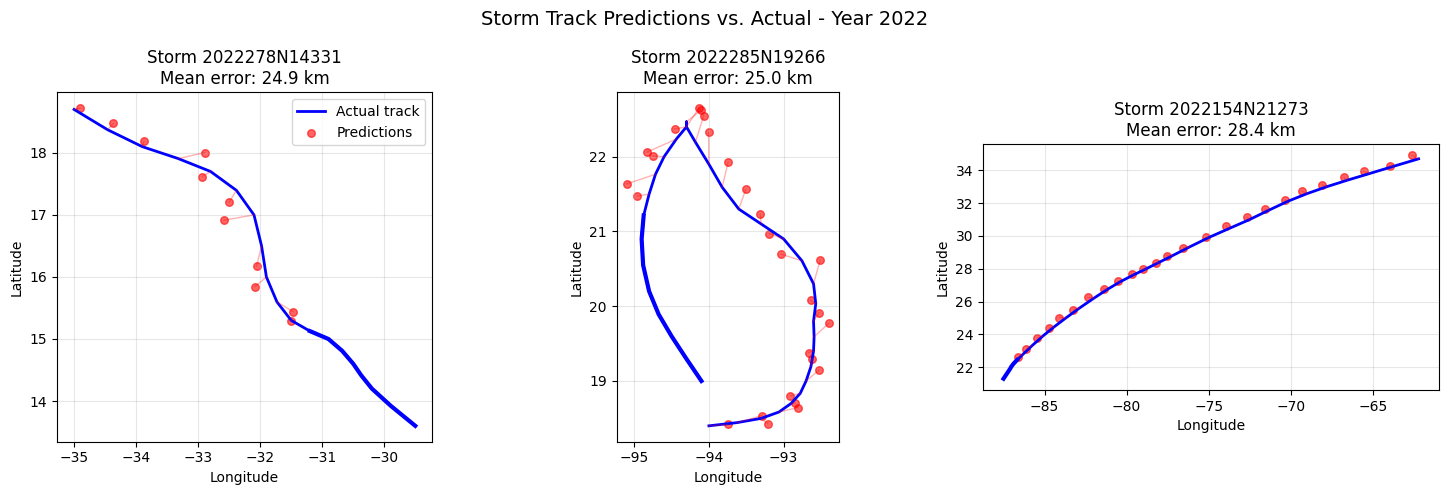

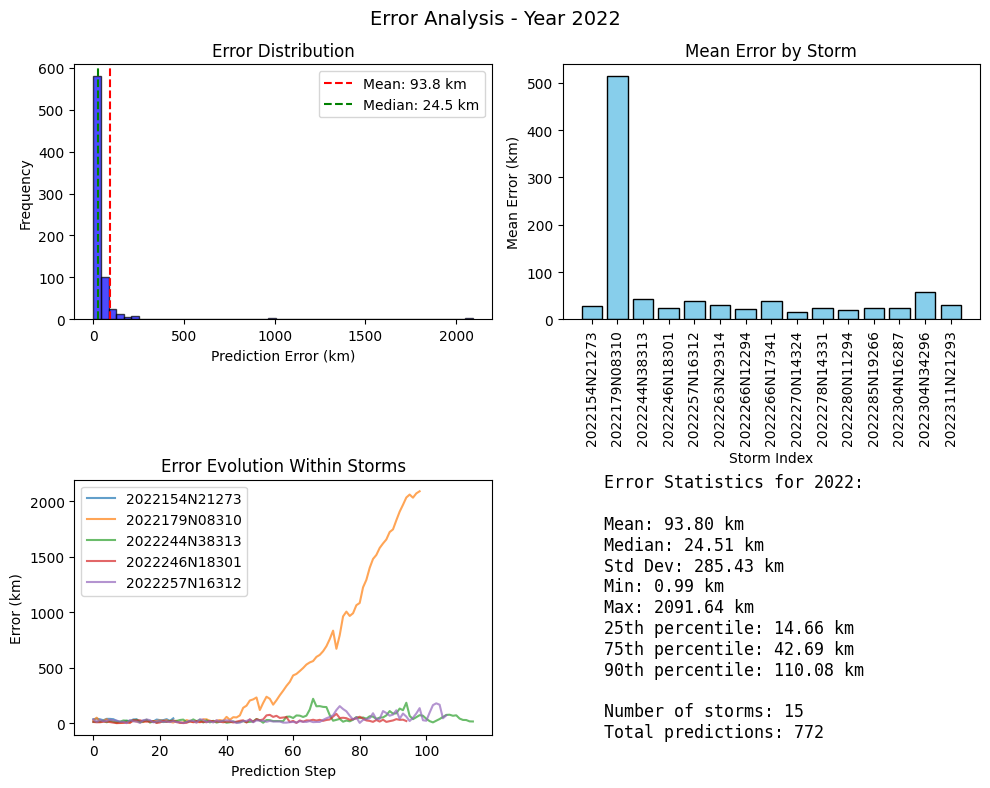

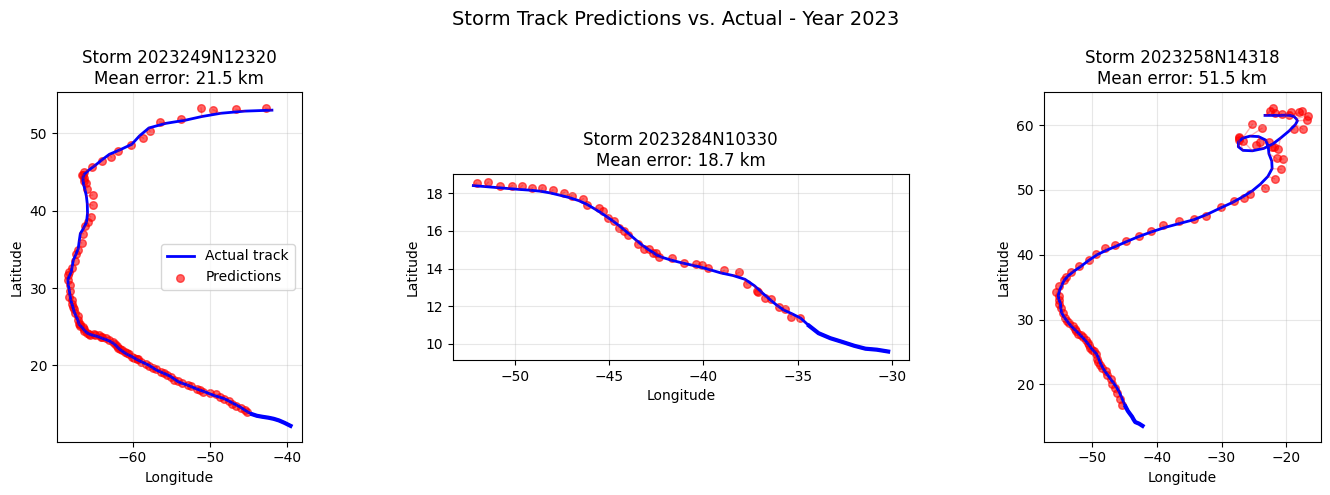

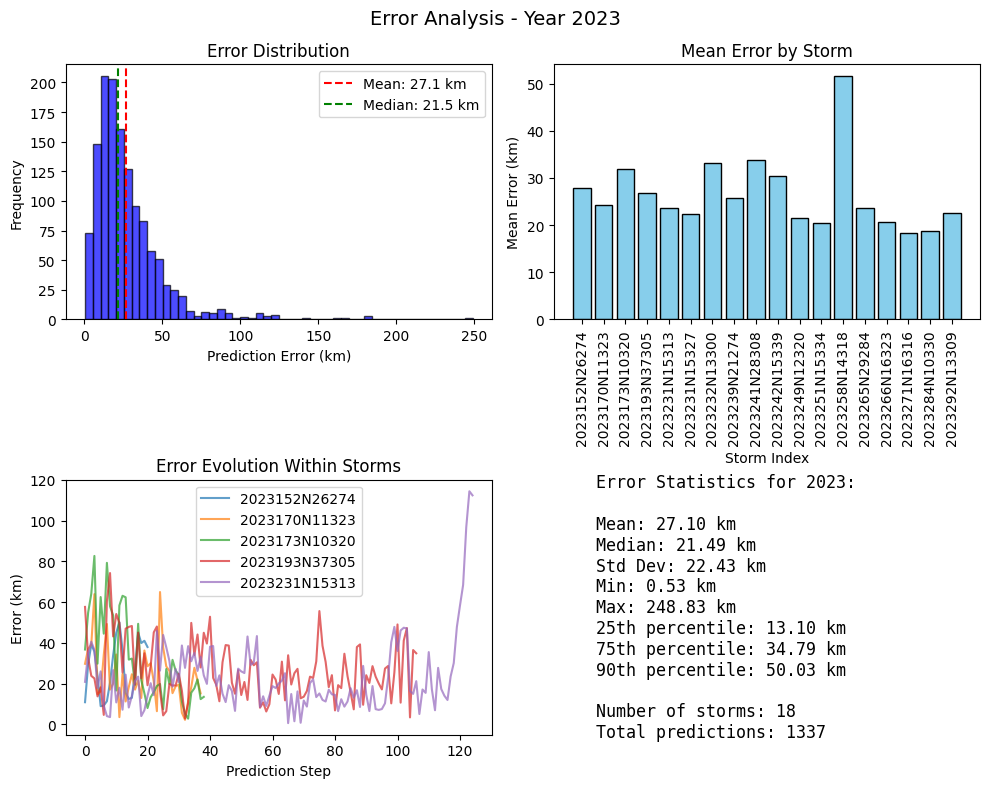

In [44]:
# Visualize predictions for each test year
np.random.seed(42)
for test_year in test_years:
    if test_year not in all_errors_by_year:
        continue

    # Select 3 random storms to visualize
    test_sids = test_predictions[test_year]['test_sids']
    selected_sids = np.random.choice(test_sids, min(3, len(test_sids)), replace=False)

    # Plot storm predictions
    plot_storm_predictions(
        trained_models[test_year],
        test_predictions[test_year],
        selected_sids,
        test_year,
        storm_start
    )
    print("\n")

    # Plot error analysis
    plot_error_analysis(all_errors_by_year[test_year], test_year)
    print("\n")

# Production Training

In [45]:
# Use all data for production model
X_all, y_all, g_all, t_all = make_windows(df, WINDOW_SIZE, HORIZON)
y_all_proj = project_targets(y_all, proj_transformer)
X_all_feat = build_feature_matrix(X_all, g_all, t_all, storm_start)

print(f"Total storms: {len(storm_years)}")
print(f"Total training windows: {len(X_all):,}")

Total storms: 1464
Total training windows: 75,301


In [46]:
# Build and train production model
production_pipeline = create_pipeline()
print("Training production model...")
production_pipeline.fit(X_all_feat, y_all_proj)

Training production model...


Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale_numeric',
                                                  StandardScaler(),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22,
                                                   23])])),
                ('hgb',
                 MultiOutputRegressor(estimator=HistGradientBoostingRegressor(l2_regularization=0.1,
                                                                              max_depth=10,
                                                                              max_iter=200,
                                                                              random_state=42)))])

In [47]:
# Save production model
joblib.dump(production_pipeline, "storm_forecast_production_model_hgb.joblib")
print("Production model saved to storm_forecast_production_model_hgb.joblib")

Production model saved to storm_forecast_production_model_hgb.joblib
